<a href="https://colab.research.google.com/github/koluzaeva/DL_intensive-MADE-/blob/main/OCR_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Финальное задание по Deep Learning Basic

### Косарева Екатерина (DS-22)

В рамках задание предлагается самостоятельно обучить модель OCR для распознавания
капчи.

###1. Для начала распаковываем архив с данными (у меня все на гугл диске) и удаляем дубликаты изображений (папка sample продублирована)

In [ ]:
!unzip '/content/drive/MyDrive/MADE/DL/laba-dataset.zip' -d '/content/drive/MyDrive/MADE/DL/data'

In [ ]:
!rm -rf '/content/drive/MyDrive/MADE/DL/data/samples/samples'

###2. Импортируем все необходимуе библиотеки

https://deepayan137.github.io/blog/markdown/2020/08/29/building-ocr.html

In [ ]:
import os
import sys
import albumentations

from PIL import Image
from PIL import ImageFile

import numpy as np
import glob

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split

from tqdm import tqdm

###3. Определяем константы.

IMAGE_WIDTH и  IMAGE_HEIGHT у всех изображений одинаковые 50*200

NUM_WORKERS = 2, так как в гугл колабе указать большее кол-во нельзя

In [ ]:
DATA_DIR = '/content/drive/MyDrive/MADE/DL/data/samples'
BATCH_SIZE = 8
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 50
NUM_WORKERS = 2
EPOCHS = 150

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

DEVICE = torch.device(device)


###3. Пишем класс для загрузки, нормализации и доступа к изображениям.

Для нормализации данных мы взяли значения 
        
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

В официальной документации https://pytorch.org/vision/stable/models.html сказано, что эти значения хорошо использовать для моделей предобученных на ImageNet. Хотя у нас другой датасет, экмперимент показал, что при таких значениях модель хорошо обучается и дает высокую точность на тестовых данных. В противном случае, нужно было бы расчитать mean и std по имеющимся данным.

In [ ]:
#Whether or not to load truncated image files. User code may change this.
ImageFile.LOAD_TRUNCATED_IMAGES = True


class OCRDataset(Dataset):
    def __init__(self, image_paths, targets, resize=None):
        #uncomment next line if images have different size
        # resize = (height, width)
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        self.aug = albumentations.Compose(
            [
                albumentations.Normalize(
                    mean, std, max_pixel_value=255.0, always_apply=True
                )
            ]
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        targets = self.targets[item]

        if self.resize is not None:
            image = image.resize(
                (self.resize[1], self.resize[0]), resample=Image.BILINEAR
            )

        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)

        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }


###4. Загружаем изображения и определяем метки

Метка изображения соответствует его названию, например, изображение `m5meg.png` имеет метку '`m5meg`'. Для того, чтобы использовть эти метки в обучении модели, нужно их кодировать.

Опишем переменные:

    `targets_orig` - оригинальные метки изображений, типа `m5meg`
    `targets` - список, где каждая метка храниться в виде списка, нр. ['m', '5', 'm', 'e', 'g']
    `targets_flat` - "развернутый" список `targets`, создается для того, чтобы кодировать символы, входящие во все названия
     изображений (всего 19 различных символов)

Далее кодируем символы и метки `targets`, получаем новый список `targets_enc`, в котором каждый символ метки представлен своим кодовым значение. Мы увеличим эти коды на **1** для того, чтобы оставить код **0** когда модель не уверена в своих предсказаниях. Таким образом, в нашей моделе будет 20 классов предсказаных символов.

После того как мы закодировали метки, разделяем все данные на трэйн и тест, причем будем разделять как кодированные метки так и оригинальные, для последующего визуального сравнения предсказаний с реальными данными.

Создаем экземпляры класса Dataset: train_dataset, test_dataset

И train_loader, test_loader для загрузки данных батчами с перемешаными данными.


In [ ]:
image_files = glob.glob(os.path.join(DATA_DIR, "*.png"))
targets_orig = [x.split("/")[-1][:-4] for x in image_files]
targets = [[c for c in x] for x in targets_orig]
targets_flat = [c for clist in targets for c in clist]

lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(targets_flat)
targets_enc = [lbl_enc.transform(x) for x in targets]
targets_enc = np.array(targets_enc)
targets_enc = targets_enc + 1
(
        train_imgs,
        test_imgs,
        train_targets,
        test_targets,
        _,
        test_targets_orig,
) = model_selection.train_test_split(
        image_files, targets_enc, targets_orig, test_size=0.2, random_state=42
        )

train_dataset = OCRDataset(
        image_paths=train_imgs,
        targets=train_targets,
        resize=(IMAGE_HEIGHT, IMAGE_WIDTH),
        )
    
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=True,
        )

test_dataset = OCRDataset(
        image_paths=test_imgs,
        targets=test_targets,
        resize=(IMAGE_HEIGHT, IMAGE_WIDTH),
        )

test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False,
        )


Посмотрим какой размер имеют наши данные

In [ ]:
train_dataset[0]['images'].shape

torch.Size([3, 50, 200])

###5. Определяем класс для модели

В качестве архитектуры модели берем CNN-LSTM предложенную в описании ДЗ, которая подробно рассмотрена в статье **An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition** (https://arxiv.org/pdf/1507.05717.pdf)




"Сетевая архитектура CRNN состоит из трех компонентов, включая 
сверточные слои, рекуррентные слои и слой транскрипции, снизу вверх.
В нижней части CRNN сверточные слои автоматически извлекают последовательность признаков из каждого входного изображения. Поверх сверточной сети строится рекуррентная сеть для предсказания каждого кадра последовательности признаков, выдаваемой сверточными слоями."

Архитектура представлена в таблице

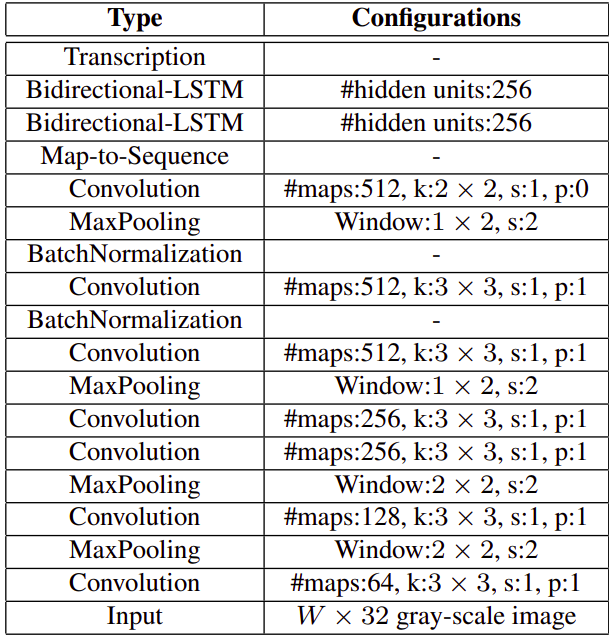


Так как размер изображений (по высоте ) всего 50 пикселей, я убрала несколько последних сверток и добавила BatchNorm после второй свертки.

После сверток добавлен линейный слой, дропаут для регуляризации и два двунаправленных рекурентных слоя. Последний слой в сети является линейный на 20 нейронов для предсказания кодов символов.

Функция forward() возвращает выходы модели и функцию потери на основе CTCLoss


In [ ]:
class OCRModel(nn.Module):
    def __init__(self, num_chars):
        super(OCRModel, self).__init__()
        self.conv_1 = nn.Conv2d(3, 64, kernel_size=3, padding=(1, 1))
        self.pool_1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_2 = nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1))
        self.batch_norm_2 = nn.BatchNorm2d(128)
        self.pool_2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_3 = nn.Conv2d(128, 256, kernel_size=3, padding=(1, 1))
        self.pool_3 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        self.conv_4 = nn.Conv2d(256, 256, kernel_size=3, padding=(1, 1))
        self.batch_norm_4 = nn.BatchNorm2d(256)
        self.pool_4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv_5 = nn.Conv2d(256, 512, kernel_size=3, padding=(1, 1))
        self.pool_5 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        self.conv_6 = nn.Conv2d(512, 512, kernel_size=3, padding=(1, 1))
        self.batch_norm_6 = nn.BatchNorm2d(512)
                
        self.linear_1 = nn.Linear(512, 512)
        self.drop_1 = nn.Dropout(0.2)
        self.lstm_1 = nn.LSTM(512, 256, bidirectional=True)
        self.linear_2 = nn.Linear(512, 256)
        self.lstm_2 = nn.LSTM(256, 256, bidirectional=True)
        self.linear_3 = nn.Linear(512, num_chars + 1)
        
  
    def forward(self, images, targets=None):
        bs, _, _, _ = images.size()
        x = F.relu(self.conv_1(images))
        x = self.pool_1(x)
        #print('con1', x.size())
        x = F.relu(self.conv_2(x))
        x = self.batch_norm_2(x)
        x = self.pool_2(x)
        #print('con2',x.size())
        x = F.relu(self.conv_3(x))
        x = self.pool_3(x)
        #print('con3',x.size())
        x = F.relu(self.conv_4(x))
        x = self.batch_norm_4(x)
        x = self.pool_4(x)
        #print('con4',x.size())
        x = F.relu(self.conv_5(x))
        x = self.pool_5(x)
        #print('con5',x.size())
        x = F.relu(self.conv_6(x))
        x = self.batch_norm_6(x)
        #print('con6',x.size())
       
        x = x.permute(0, 3, 1, 2)
        #print('permute',x.size())
        x = x.view(bs, x.size(1), -1)
        #print('view',x.size())
        x = F.relu(self.linear_1(x))
        #print('relu',x.size())
        x = self.drop_1(x)
        x, _ = self.lstm_1(x)
        #print('lstm1', x.size())
        x = self.linear_2(x)
        #print('linear2', x.size())
        x, _ = self.lstm_2(x)
        #print('lstm2', x.size())
        x = self.linear_3(x)
        #print('linear3', x.size())
        
        #x = self.output(x)
        #print('out', x.size())
        x = x.permute(1, 0, 2)
        #print('permute', x.size())

        if targets is not None:
            log_probs = F.log_softmax(x, 2)
            input_lengths = torch.full(
                size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32
            )
            target_lengths = torch.full(
                size=(bs,), fill_value=targets.size(1), dtype=torch.int32
            )
            loss = nn.CTCLoss(blank=0)(
                log_probs, targets, input_lengths, target_lengths
            )
            return x, loss

        return x, None



###6. Определяем функции для обучения и валидации модели

In [ ]:
from tqdm import tqdm
import torch


def train_fn(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(DEVICE)
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()
    return fin_loss / len(data_loader)


def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    tk0 = tqdm(data_loader, total=len(data_loader))
    for data in tk0:
        for key, value in data.items():
            data[key] = value.to(DEVICE)
        batch_preds, loss = model(**data)
        fin_loss += loss.item()
        fin_preds.append(batch_preds)
    return fin_preds, fin_loss / len(data_loader)

###7. Определяем функции для "чистки" прогнозов и декодирования предсказанных меток в оригинальный вид

Функция remove_duplicates() удаляет дублируемые символ(одинаковые символы, идущие подряд)

Функция decode_predictions(preds, encoder) переводит класс предсказанного символа обратно в символ, если предсказанный класс равен 0 (соответствует тому, что модель не определила символ), то в предсказанною последовательность вставляется "§" (это может быть любой символ не входящий в обучаемый алфавит) и удаляет дубликаты.

In [ ]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    prev = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == prev:
                continue
            else:
                fin = fin + j
        prev = j
    return fin

def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append("§")
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(p)
        tp = "".join(remove_duplicates(temp)).replace("§", "")
        cap_preds.append(tp)
    return cap_preds

###8. Инициализируем и обучаем модель

В качестве оптимизатора берем Adam с параметрами модели и скоростью обучения 0,0003, которую уменьшать, когда метрики качества модели(тест лосс) перестают явно улучшаться в течении 5 эпох.

Для наглядности после каждой эпохи выводим 10 первых тестовых меток и их предсказаное значение, а также ошибку обучения, ошибку тестирования и точность тестирования, расчитанную как доля верно предсказанных меток.

In [ ]:
model = OCRModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
    )
for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer)
    valid_preds, test_loss = eval_fn(model, test_loader)
    valid_captcha_preds = []
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_captcha_preds.extend(current_preds)

    combined = list(zip(test_targets_orig, valid_captcha_preds))
    print(combined[:10])
    
    #test_dup_rem = [remove_duplicates(c) for c in test_targets_orig]
    accuracy = metrics.accuracy_score(test_targets_orig, valid_captcha_preds)
    print(
            f"Epoch={epoch}, Train Loss={train_loss}, Test Loss={test_loss} Accuracy={accuracy}"
        )
    scheduler.step(test_loss)

100%|██████████| 26/26 [00:00<00:00, 29.84it/s]


[('5ywwf', ''), ('m5meg', ''), ('6mn8n', ''), ('3xng6', ''), ('n2by7', ''), ('y5g87', ''), ('8n65n', ''), ('bdg84', ''), ('een23', ''), ('cfp86', '')]
Epoch=0, Train Loss=3.911241265443655, Test Loss=3.280753438289349 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 46.82it/s]


[('5ywwf', ''), ('m5meg', ''), ('6mn8n', ''), ('3xng6', ''), ('n2by7', ''), ('y5g87', ''), ('8n65n', ''), ('bdg84', ''), ('een23', ''), ('cfp86', '')]
Epoch=1, Train Loss=3.2669105919507833, Test Loss=3.270546262080853 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 45.44it/s]


[('5ywwf', ''), ('m5meg', ''), ('6mn8n', ''), ('3xng6', ''), ('n2by7', ''), ('y5g87', ''), ('8n65n', ''), ('bdg84', ''), ('een23', ''), ('cfp86', '')]
Epoch=2, Train Loss=3.2653370178662815, Test Loss=3.260362845200759 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 44.08it/s]


[('5ywwf', ''), ('m5meg', ''), ('6mn8n', ''), ('3xng6', ''), ('n2by7', ''), ('y5g87', ''), ('8n65n', ''), ('bdg84', ''), ('een23', ''), ('cfp86', '')]
Epoch=3, Train Loss=3.2606671108649325, Test Loss=3.2565938967924852 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 46.24it/s]


[('5ywwf', ''), ('m5meg', ''), ('6mn8n', ''), ('3xng6', ''), ('n2by7', ''), ('y5g87', ''), ('8n65n', ''), ('bdg84', ''), ('een23', ''), ('cfp86', '')]
Epoch=4, Train Loss=3.246618518462548, Test Loss=3.2193021224095273 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 46.22it/s]


[('5ywwf', ''), ('m5meg', ''), ('6mn8n', ''), ('3xng6', ''), ('n2by7', ''), ('y5g87', ''), ('8n65n', ''), ('bdg84', ''), ('een23', ''), ('cfp86', '')]
Epoch=5, Train Loss=3.072045697615697, Test Loss=2.8871021820948672 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 47.13it/s]


[('5ywwf', ''), ('m5meg', 'nn'), ('6mn8n', 'nn'), ('3xng6', 'n'), ('n2by7', 'n'), ('y5g87', ''), ('8n65n', 'nn'), ('bdg84', ''), ('een23', 'n'), ('cfp86', 'n')]
Epoch=6, Train Loss=2.557422420153251, Test Loss=2.346699412052448 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 31.28it/s]


[('5ywwf', '57'), ('m5meg', 'p7ng'), ('6mn8n', 'nnn'), ('3xng6', '77n'), ('n2by7', 'n77'), ('y5g87', '77g7'), ('8n65n', 'n7n'), ('bdg84', '7'), ('een23', 'n7'), ('cfp86', 'p')]
Epoch=7, Train Loss=2.099964678287506, Test Loss=2.091424850317148 Accuracy=0.0


100%|██████████| 26/26 [00:00<00:00, 47.07it/s]


[('5ywwf', '5ywww'), ('m5meg', 'n5neg'), ('6mn8n', '6nn8n'), ('3xng6', '5yng6'), ('n2by7', 'nbby5'), ('y5g87', 'y5g85'), ('8n65n', '8n65n'), ('bdg84', 'bdg8d'), ('een23', 'een25'), ('cfp86', '6fp86')]
Epoch=8, Train Loss=1.4888429206151228, Test Loss=1.202833932179671 Accuracy=0.038461538461538464


100%|██████████| 26/26 [00:00<00:00, 46.58it/s]


[('5ywwf', '3ywwf'), ('m5meg', 'n3nmeg'), ('6mn8n', '6nnb8n'), ('3xng6', '7ymg6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g83'), ('8n65n', '8n67n'), ('bdg84', 'b4dg84'), ('een23', 'een23'), ('cfp86', '6fp86')]
Epoch=9, Train Loss=1.0217102422164037, Test Loss=0.8093312336848333 Accuracy=0.18269230769230768


100%|██████████| 26/26 [00:00<00:00, 46.28it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5mcg'), ('6mn8n', '6mn8n'), ('3xng6', '7xmg6'), ('n2by7', 'm2dy7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'eem25'), ('cfp86', 'cfp86')]
Epoch=10, Train Loss=0.6866927937819407, Test Loss=0.559260158584668 Accuracy=0.4326923076923077


100%|██████████| 26/26 [00:00<00:00, 38.11it/s]


[('5ywwf', '3ywwf'), ('m5meg', 'm3meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xmg6'), ('n2by7', 'n2by7'), ('y5g87', 'y3g87'), ('8n65n', '8n63n'), ('bdg84', 'bdg84'), ('een23', 'eem23'), ('cfp86', 'efp86')]
Epoch=11, Train Loss=0.4757322004208198, Test Loss=0.4685897918847891 Accuracy=0.44711538461538464


100%|██████████| 26/26 [00:00<00:00, 45.89it/s]


[('5ywwf', 'ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mmn8n'), ('3xng6', '7xmg6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'eemn25'), ('cfp86', 'cfp86')]
Epoch=12, Train Loss=0.33613575980640376, Test Loss=0.28148932869617754 Accuracy=0.6298076923076923


100%|██████████| 26/26 [00:00<00:00, 45.59it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een25'), ('cfp86', 'cfp86')]
Epoch=13, Train Loss=0.2740802275590025, Test Loss=0.2275057159937345 Accuracy=0.6442307692307693


100%|██████████| 26/26 [00:00<00:00, 28.08it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mm8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65m'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=14, Train Loss=0.22463913183086193, Test Loss=0.20660773263527796 Accuracy=0.7836538461538461


100%|██████████| 26/26 [00:00<00:00, 43.91it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'n5nmeg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=15, Train Loss=0.14502448545625576, Test Loss=0.1440016610118059 Accuracy=0.8942307692307693


100%|██████████| 26/26 [00:00<00:00, 45.32it/s]


[('5ywwf', 'ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '7xmng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp8f')]
Epoch=16, Train Loss=0.11962402611970901, Test Loss=0.14994301962164733 Accuracy=0.8846153846153846


100%|██████████| 26/26 [00:00<00:00, 48.01it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdgb84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=17, Train Loss=0.08728327114994709, Test Loss=0.06727228542933097 Accuracy=0.9663461538461539


100%|██████████| 26/26 [00:00<00:00, 28.89it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=18, Train Loss=0.07849502579595607, Test Loss=0.07884249635613881 Accuracy=0.9278846153846154


100%|██████████| 26/26 [00:00<00:00, 46.09it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=19, Train Loss=0.07131761686804776, Test Loss=0.054434158910925574 Accuracy=0.9519230769230769


100%|██████████| 26/26 [00:00<00:00, 44.76it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=20, Train Loss=0.09046793363701838, Test Loss=0.12475268270533818 Accuracy=0.8846153846153846


100%|██████████| 26/26 [00:00<00:00, 45.08it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=21, Train Loss=0.06840731237585154, Test Loss=0.06968150144586197 Accuracy=0.9519230769230769


100%|██████████| 26/26 [00:00<00:00, 47.05it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp8c6')]
Epoch=22, Train Loss=0.04657519752016434, Test Loss=0.0702877021036469 Accuracy=0.9230769230769231


100%|██████████| 26/26 [00:00<00:00, 45.64it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=23, Train Loss=0.06268622618741714, Test Loss=0.04360187196960816 Accuracy=0.9759615384615384


100%|██████████| 26/26 [00:00<00:00, 45.52it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=24, Train Loss=0.049446119067187495, Test Loss=0.051164609236786 Accuracy=0.9711538461538461


100%|██████████| 26/26 [00:00<00:00, 28.29it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=25, Train Loss=0.0693932627954592, Test Loss=0.08485040118774542 Accuracy=0.9326923076923077


100%|██████████| 26/26 [00:00<00:00, 44.95it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=26, Train Loss=0.05350033345166594, Test Loss=0.04186944402037905 Accuracy=0.9567307692307693


100%|██████████| 26/26 [00:00<00:00, 47.57it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=27, Train Loss=0.031834438479003996, Test Loss=0.042992516384961516 Accuracy=0.9615384615384616


100%|██████████| 26/26 [00:00<00:00, 45.16it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=28, Train Loss=0.02096880826418503, Test Loss=0.07302043565477316 Accuracy=0.9615384615384616


100%|██████████| 26/26 [00:01<00:00, 22.10it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=29, Train Loss=0.028521661852629714, Test Loss=0.05263928288164047 Accuracy=0.9567307692307693


100%|██████████| 26/26 [00:00<00:00, 46.28it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=30, Train Loss=0.07560348831332074, Test Loss=0.030983735592319414 Accuracy=0.9807692307692307


100%|██████████| 26/26 [00:00<00:00, 43.88it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', 'xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n6c5n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=31, Train Loss=0.051616096833290964, Test Loss=0.08049127026102863 Accuracy=0.9423076923076923


100%|██████████| 26/26 [00:00<00:00, 32.59it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', 'xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=32, Train Loss=0.037289094914180726, Test Loss=0.11414650892122434 Accuracy=0.9038461538461539


100%|██████████| 26/26 [00:00<00:00, 47.41it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=33, Train Loss=0.08807596241016515, Test Loss=0.04713888695606819 Accuracy=0.9567307692307693


100%|██████████| 26/26 [00:00<00:00, 45.19it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cwfp86')]
Epoch=34, Train Loss=0.05653376595224612, Test Loss=0.03900887931768711 Accuracy=0.9567307692307693


100%|██████████| 26/26 [00:00<00:00, 43.92it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=35, Train Loss=0.04075396216761034, Test Loss=0.036463368469132826 Accuracy=0.9807692307692307


100%|██████████| 26/26 [00:00<00:00, 29.02it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2y7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=36, Train Loss=0.02903817799121428, Test Loss=0.016171411557409626 Accuracy=0.9759615384615384


100%|██████████| 26/26 [00:00<00:00, 44.50it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=37, Train Loss=0.01530669913895858, Test Loss=0.008310938970400738 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 44.33it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=38, Train Loss=0.014925146112755801, Test Loss=0.007666166477765028 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 46.09it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=39, Train Loss=0.013383544139707318, Test Loss=0.013387320007985601 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 45.28it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=40, Train Loss=0.010800245750802927, Test Loss=0.009521185868204786 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.39it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=41, Train Loss=0.009953285901037116, Test Loss=0.013228464549264083 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 44.86it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=42, Train Loss=0.013145255771143219, Test Loss=0.00687539315997408 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 29.78it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=43, Train Loss=0.011072876102004487, Test Loss=0.007154276066173155 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.41it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=44, Train Loss=0.017379791704185594, Test Loss=0.005920625345494885 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 46.45it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'nby7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=45, Train Loss=0.05739748473458279, Test Loss=0.10680848231109288 Accuracy=0.9471153846153846


100%|██████████| 26/26 [00:00<00:00, 45.50it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=46, Train Loss=0.037229174483889856, Test Loss=0.01148984289298264 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 29.36it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=47, Train Loss=0.014983376819425477, Test Loss=0.025390859487323232 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 46.26it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=48, Train Loss=0.014559438288695393, Test Loss=0.01000623085285322 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 43.83it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=49, Train Loss=0.009999418183444785, Test Loss=0.012876932115222398 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 38.40it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=50, Train Loss=0.015728575882698912, Test Loss=0.004646769877021702 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 46.22it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=51, Train Loss=0.032248486565479725, Test Loss=0.011110343110675994 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 46.42it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=52, Train Loss=0.010474228132247495, Test Loss=0.004268932362230351 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 47.74it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'cen23'), ('cfp86', 'cfp86')]
Epoch=53, Train Loss=0.035261416308528096, Test Loss=0.031120344190500103 Accuracy=0.9807692307692307


100%|██████████| 26/26 [00:00<00:00, 28.63it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=54, Train Loss=0.007986490963958204, Test Loss=0.003203090002688651 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 45.69it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=55, Train Loss=0.005632996571456226, Test Loss=0.002768019388895482 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 29.65it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=56, Train Loss=0.005459373887368621, Test Loss=0.014042473075768122 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 28.56it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=57, Train Loss=0.005094890416680405, Test Loss=0.004838628542179672 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.19it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=58, Train Loss=0.00493624070189141, Test Loss=0.008541289005034532 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.88it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=59, Train Loss=0.0046791942284191744, Test Loss=0.0023103060353045855 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 46.07it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=60, Train Loss=0.00469900272862735, Test Loss=0.0016650661933594025 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 28.69it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=61, Train Loss=0.0044215899229479525, Test Loss=0.0014918112742284744 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 45.60it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=62, Train Loss=0.004120840464355961, Test Loss=0.0015222231718675734 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 43.84it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=63, Train Loss=0.004098027154283885, Test Loss=0.007961794167595845 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 36.97it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=64, Train Loss=0.0034735456938506104, Test Loss=0.011235511637865923 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.30it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=65, Train Loss=0.00696901809827138, Test Loss=0.010317823898871072 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 45.25it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'en23'), ('cfp86', 'cfp86')]
Epoch=66, Train Loss=0.023565136586302497, Test Loss=0.05522633396769659 Accuracy=0.9375


100%|██████████| 26/26 [00:00<00:00, 44.83it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=67, Train Loss=0.022763008950278163, Test Loss=0.009526094027723257 Accuracy=0.9855769230769231
Epoch 00068: reducing learning rate of group 0 to 2.4000e-04.


100%|██████████| 26/26 [00:00<00:00, 28.21it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n24by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=68, Train Loss=0.03248463556295834, Test Loss=0.00858489554733611 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 44.95it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=69, Train Loss=0.019243173699718542, Test Loss=0.009378909348295284 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 46.31it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=70, Train Loss=0.023873019697090898, Test Loss=0.004220475281517093 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 45.84it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=71, Train Loss=0.005824318255270975, Test Loss=0.002945046889810608 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 34.09it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=72, Train Loss=0.006497532903897361, Test Loss=0.003792960057930591 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.87it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=73, Train Loss=0.006296824593356667, Test Loss=0.019900296443106178 Accuracy=0.9903846153846154
Epoch 00074: reducing learning rate of group 0 to 1.9200e-04.


100%|██████████| 26/26 [00:00<00:00, 43.26it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '5xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=74, Train Loss=0.011959366644777428, Test Loss=0.012477833043354062 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 27.57it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=75, Train Loss=0.008851766999354228, Test Loss=0.00891540529510866 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 43.80it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=76, Train Loss=0.004787258679593483, Test Loss=0.013652547276041541 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 44.85it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=77, Train Loss=0.00644415207408691, Test Loss=0.006738687278881956 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 46.37it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=78, Train Loss=0.005355448352369981, Test Loss=0.001979746860272896 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 29.65it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=79, Train Loss=0.004318212076703696, Test Loss=0.0028487097498817514 Accuracy=1.0
Epoch 00080: reducing learning rate of group 0 to 1.5360e-04.


100%|██████████| 26/26 [00:00<00:00, 44.72it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=80, Train Loss=0.00972523746223977, Test Loss=0.016264273861172393 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 44.31it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=81, Train Loss=0.009385331860707643, Test Loss=0.014061125064752279 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 42.08it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=82, Train Loss=0.003945706504544852, Test Loss=0.013661086695859782 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.11it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=83, Train Loss=0.0036946827934186263, Test Loss=0.012989339557512162 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.59it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=84, Train Loss=0.0046425778564298525, Test Loss=0.00547981527275764 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.45it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=85, Train Loss=0.014060978255516741, Test Loss=0.012549283627707224 Accuracy=0.9855769230769231
Epoch 00086: reducing learning rate of group 0 to 1.2288e-04.


100%|██████████| 26/26 [00:00<00:00, 29.68it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=86, Train Loss=0.0063557969456619155, Test Loss=0.0050655854328607135 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 46.97it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=87, Train Loss=0.00397103040282113, Test Loss=0.0012587228937683483 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 45.81it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=88, Train Loss=0.004063524917000905, Test Loss=0.016691080849761 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 43.98it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=89, Train Loss=0.0036500139210077645, Test Loss=0.011931810720572965 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 43.98it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=90, Train Loss=0.0032153260875090314, Test Loss=0.011022933174479896 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.79it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=91, Train Loss=0.0031113161639950704, Test Loss=0.015574486939630542 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 47.26it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=92, Train Loss=0.002967961792679629, Test Loss=0.011075763934059069 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 27.65it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=93, Train Loss=0.003338488118830495, Test Loss=0.0040835329922489245 Accuracy=0.9951923076923077
Epoch 00094: reducing learning rate of group 0 to 9.8304e-05.


100%|██████████| 26/26 [00:00<00:00, 46.33it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=94, Train Loss=0.002171151605580235, Test Loss=0.00888796767909438 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 44.56it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=95, Train Loss=0.004299318171923425, Test Loss=0.0057476681563107725 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 47.42it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=96, Train Loss=0.0020564231521208198, Test Loss=0.00442189575271466 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 29.81it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=97, Train Loss=0.002076674318791797, Test Loss=0.0006475243348037251 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 47.10it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=98, Train Loss=0.0020743656538028377, Test Loss=0.005655986588233366 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 46.75it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=99, Train Loss=0.0020781876312237447, Test Loss=0.0007189954205666884 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 39.29it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=100, Train Loss=0.0020902241703879554, Test Loss=0.007879726390596122 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 43.21it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=101, Train Loss=0.0020904194484151397, Test Loss=0.0010539460647403477 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 43.74it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=102, Train Loss=0.0019600712822956177, Test Loss=0.0048111788715826925 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 46.23it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=103, Train Loss=0.0020051642753130114, Test Loss=0.004182529080515871 Accuracy=0.9951923076923077
Epoch 00104: reducing learning rate of group 0 to 7.8643e-05.


100%|██████████| 26/26 [00:00<00:00, 27.37it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=104, Train Loss=0.0019644007314547286, Test Loss=0.006068294432435113 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.77it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=105, Train Loss=0.001973831827714233, Test Loss=0.006306138290361 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 43.27it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=106, Train Loss=0.0019978216441813856, Test Loss=0.0005466311894661675 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 44.91it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=107, Train Loss=0.0017343347280984744, Test Loss=0.004951861498949046 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 38.93it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=108, Train Loss=0.0018465106592115122, Test Loss=0.0005080010753142863 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 43.92it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=109, Train Loss=0.002033106001852922, Test Loss=0.0004977342345787642 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 46.29it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=110, Train Loss=0.0018590506563039245, Test Loss=0.006325325523413574 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 28.08it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=111, Train Loss=0.0016130803444236964, Test Loss=0.0004570880286897031 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 45.27it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=112, Train Loss=0.0016673360741361438, Test Loss=0.007014741522233145 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 42.07it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=113, Train Loss=0.0017345253318825809, Test Loss=0.006858959036225525 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 37.69it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=114, Train Loss=0.0016767286085199045, Test Loss=0.0049113731874967925 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 28.12it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=115, Train Loss=0.0018019797570069875, Test Loss=0.0039805014418491805 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.28it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=116, Train Loss=0.0017037268970363163, Test Loss=0.00717162950828564 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.07it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=117, Train Loss=0.0015935452342651284, Test Loss=0.00038721898006490216 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 41.14it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=118, Train Loss=0.0017912762533132292, Test Loss=0.0004963083371806603 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 47.27it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=119, Train Loss=0.0032393236426567175, Test Loss=0.014215853829227854 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 42.76it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=120, Train Loss=0.0016704977718361008, Test Loss=0.013015237996184554 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.24it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=121, Train Loss=0.0016051435297693107, Test Loss=0.013258009602745565 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 27.81it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=122, Train Loss=0.0020302160008633598, Test Loss=0.01575934990922598 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 47.29it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=123, Train Loss=0.005955815000421493, Test Loss=0.012320962644410498 Accuracy=0.9855769230769231
Epoch 00124: reducing learning rate of group 0 to 6.2915e-05.


100%|██████████| 26/26 [00:00<00:00, 45.27it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=124, Train Loss=0.0027788234361091433, Test Loss=0.002197513751945315 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 41.30it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=125, Train Loss=0.0015790039320003975, Test Loss=0.0076359284201036924 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 41.81it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=126, Train Loss=0.0015492757790455541, Test Loss=0.0026756650382034983 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.68it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=127, Train Loss=0.0014824318602152814, Test Loss=0.0019027568929371997 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.55it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=128, Train Loss=0.0016793818607626376, Test Loss=0.006798384674206877 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 28.38it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=129, Train Loss=0.0022603628896411885, Test Loss=0.005726561101954968 Accuracy=0.9903846153846154
Epoch 00130: reducing learning rate of group 0 to 5.0332e-05.


100%|██████████| 26/26 [00:00<00:00, 45.19it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=130, Train Loss=0.0017441031159250997, Test Loss=0.0003709623997565359 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 43.44it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=131, Train Loss=0.0012802048680056871, Test Loss=0.0006293372470491494 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 44.95it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=132, Train Loss=0.0013402179311714673, Test Loss=0.0037234669983333265 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 29.14it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=133, Train Loss=0.001406280219900789, Test Loss=0.00029307759485583607 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 44.81it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=134, Train Loss=0.001392617661622353, Test Loss=0.00030310784887450817 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 46.88it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=135, Train Loss=0.0012360896267077455, Test Loss=0.0005249597329216508 Accuracy=1.0


100%|██████████| 26/26 [00:00<00:00, 38.98it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=136, Train Loss=0.0008844942345044379, Test Loss=0.004319152367735604 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.31it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=137, Train Loss=0.0016873859854408342, Test Loss=0.011633597041789191 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.48it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=138, Train Loss=0.0014587123850315737, Test Loss=0.009553723117278423 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 44.65it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=139, Train Loss=0.0009174356185982246, Test Loss=0.014478085781984892 Accuracy=0.9903846153846154
Epoch 00140: reducing learning rate of group 0 to 4.0265e-05.


100%|██████████| 26/26 [00:00<00:00, 28.38it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=140, Train Loss=0.0007330590602018324, Test Loss=0.008975757667940343 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 28.13it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=141, Train Loss=0.0005465934257769662, Test Loss=0.010977167414519219 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 43.74it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=142, Train Loss=0.0003250007581440374, Test Loss=0.005967930068716389 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 27.31it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=143, Train Loss=0.00022630079393610897, Test Loss=0.008314551755924745 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 42.54it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=144, Train Loss=0.0003049715999692965, Test Loss=0.01095524819930478 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 45.88it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=145, Train Loss=0.00027628942286985245, Test Loss=0.011651563662151322 Accuracy=0.9903846153846154
Epoch 00146: reducing learning rate of group 0 to 3.2212e-05.


100%|██████████| 26/26 [00:00<00:00, 44.56it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=146, Train Loss=0.00020931712592405698, Test Loss=0.007738567019819479 Accuracy=0.9951923076923077


100%|██████████| 26/26 [00:00<00:00, 30.67it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=147, Train Loss=0.00017782092275480792, Test Loss=0.01416954989046924 Accuracy=0.9903846153846154


100%|██████████| 26/26 [00:00<00:00, 42.70it/s]


[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=148, Train Loss=0.0003419156757725152, Test Loss=0.0329994335462778 Accuracy=0.9855769230769231


100%|██████████| 26/26 [00:00<00:00, 44.77it/s]

[('5ywwf', '5ywwf'), ('m5meg', 'm5meg'), ('6mn8n', '6mn8n'), ('3xng6', '3xng6'), ('n2by7', 'n2by7'), ('y5g87', 'y5g87'), ('8n65n', '8n65n'), ('bdg84', 'bdg84'), ('een23', 'een23'), ('cfp86', 'cfp86')]
Epoch=149, Train Loss=0.0008034209545607715, Test Loss=0.017842720118866194 Accuracy=0.9903846153846154


Выведем количество параметров модели:

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

7536532


###9. Рассчет метрики Character Error Rate (CER)

Видим, что точность тестирования очень высокая > 99 %. Хотя сеть немного переобучена, так как за последние 25 эпох не наблюдалось существенного улучшения по потерям тестирования.

Для расчета Character Error Rate (CER) воспользуемся библиотекой torchmetrics, которая содержит готовую реализацию этой метрики 

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 27.5 MB/s eta 0:00:00


*Пример работы  CharErrorRate*

In [ ]:
from torchmetrics import CharErrorRate
preds = ["this is the prediction", "there is an other sample"]
target = ["this is the reference", "there is another one"]
cer = CharErrorRate()
cer(preds, target)

tensor(0.3415)

Рассчитаем  CharErrorRate для тестовых меток. 


In [ ]:
print(cer(test_targets_orig, valid_captcha_preds))

tensor(0.0019)


Посмотрим на каких метках модель ошиблась

In [ ]:
err_cnt = 0

for x, y in zip(test_targets_orig, valid_captcha_preds):
  if x != y:
    err_cnt += 1
    print(f'Real label {x}, predicted label {y}')

Real label pdyc8, predicted label pdywc8
Real label y2ye8, predicted label y2e8


Выведем эти картинки

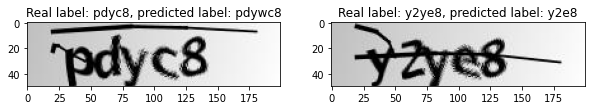

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig = plt.figure(figsize=(10, 20))
i = 1
for x, y in zip(test_targets_orig, valid_captcha_preds):
  if x != y:
    img = mpimg.imread(os.path.join(DATA_DIR, str(x) + ".png"))
    ax = fig.add_subplot(1, 2, i)
    ax.set_title(f'Real label: {x}, predicted label: {y}')
    imgplot = plt.imshow(img)
    i += 1


На первый взгляд кажется, что модель не смогла распознать символы, которые достаточно сильно размыты. 

**Возможное решение** - сделать аугментацию данных обучения с применением различных фильтров.  

**Замечание**. Ребята в дискорде писали, что в данных есть ошибки, поэтому натренировать модель до cer=1.0 не получится